In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import os 

# hypothesis testing 
from scipy.stats import shapiro
import scipy.stats as stats

path = "/Users/chq-trangd/Downloads/cookie_cats.csv/cookie_cats.csv"

data = pd.read_csv(path)

Summary of data background: 
userid - a unique number that identifies each player.
version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
sum_gamerounds - the number of game rounds played by the player during the first week after installation
retention_1 - did the player come back and play 1 day after installing?
retention_7 - did the player come back and play 7 days after installing?

In [4]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
## checking data importing 
print(data.shape)
print(data[data.isna() ==True].count())
print(data.dtypes)

(90189, 5)
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object


In [6]:
data.describe()  # only 1 variable that is integer

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [7]:
# A/B group testing and the target summary stats -- number of gamerounds the players paly 
data.groupby("version",as_index=False).sum_gamerounds.agg(["count","median","mean","std","max"])

,version,count,median,mean,std,max
0,gate_30,44700,17.0,52.456264,256.716423,49854
1,gate_40,45489,16.0,51.298776,103.294416,2640


Text(0.5, 1.0, 'Distribution of Two Groups')

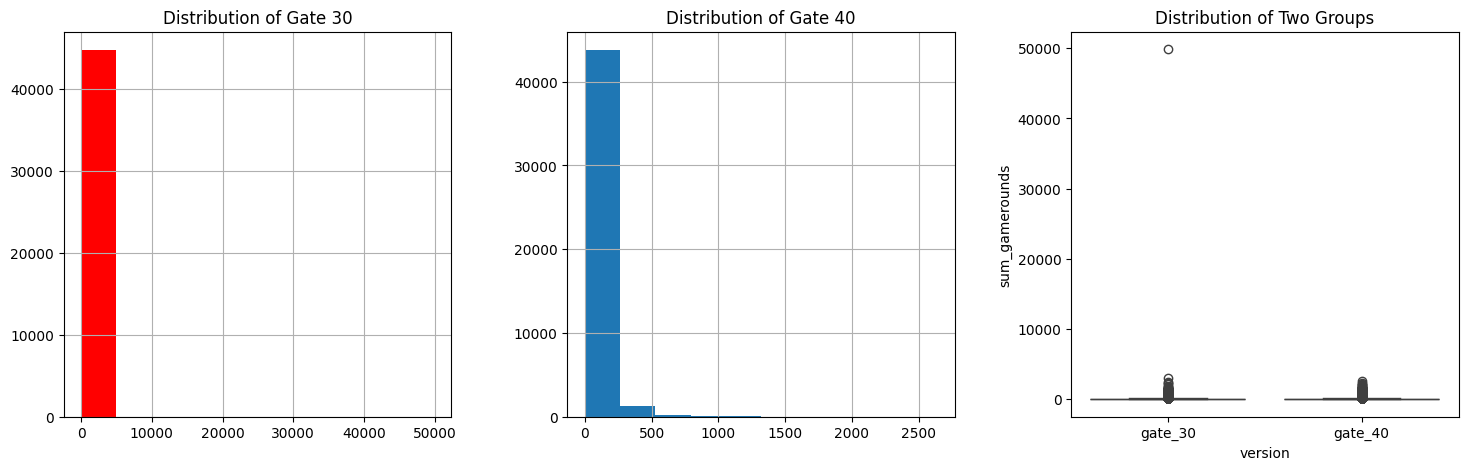

In [8]:
# distribution of each A/B group testing without removing outliner 

fig,axes = plt.subplots(1,3,figsize=(18,5))

data.query('version=="gate_30"').hist("sum_gamerounds",ax=axes[0],color='red')
axes[0].set_title("Distribution of Gate 30")

data.query('version=="gate_40"').hist("sum_gamerounds",ax=axes[1])
axes[1].set_title("Distribution of Gate 40")

## distribution of the two groups together

sns.boxplot(data, x = data['version'],y=data['sum_gamerounds'],ax=axes[2])
axes[2].set_title("Distribution of Two Groups")


There are outliners in gate_30 group that need further investigation. 

In [9]:
game_max = data['sum_gamerounds'].max()
print(game_max)
outlinears = data[(data['version']=='gate_30') & (data['sum_gamerounds']==game_max)] 

49854


In [10]:
clean_data = data[data['sum_gamerounds']<data['sum_gamerounds'].max()]

Text(0.5, 1.0, 'Clean Data Distribution for 2 groups')

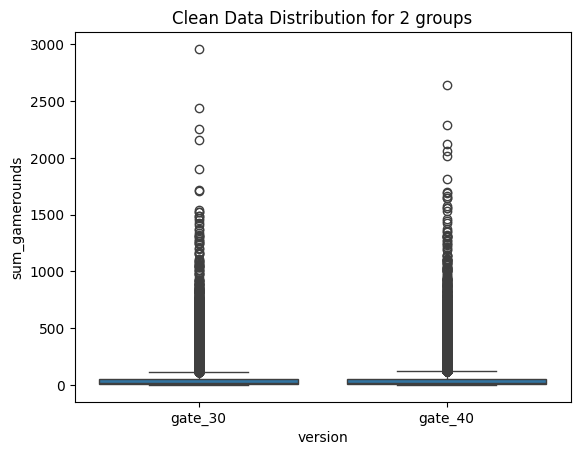

In [11]:
## redrawing the distribution after removing outliers
sns.boxplot(x=clean_data['version'], y = clean_data['sum_gamerounds']).set_title("Clean Data Distribution for 2 groups")

#### Futher investigation into the Data 

In [12]:
clean_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [13]:
## number of users installing the game but do not play 

clean_data.query('sum_gamerounds==0').count()

userid            3994
version           3994
sum_gamerounds    3994
retention_1       3994
retention_7       3994
dtype: int64

<Axes: title={'center': 'Number of players per game level'}>

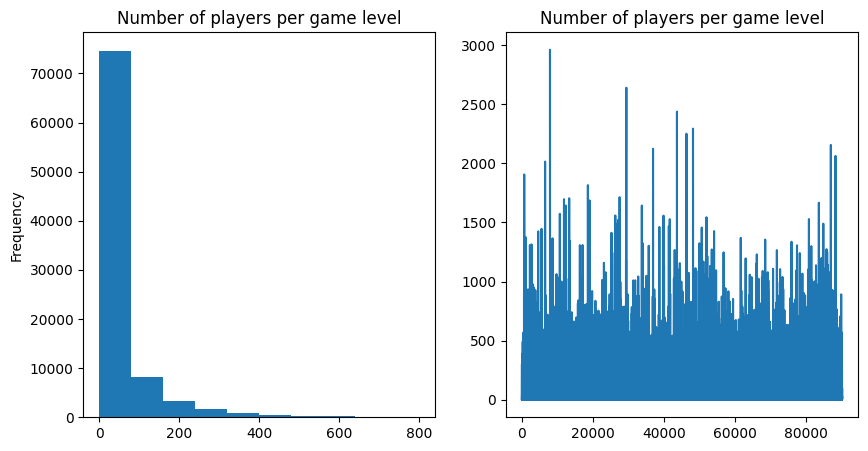

In [42]:
## number of user playing based on sum_gamerounds, assuming higher sum_gamerounds indicating higher level 
fig,axes = plt.subplots(1,2,figsize=(10,5))
#clean_data.hist('sum_gamerounds',range = (0,800),ax = axes[0])
clean_data['sum_gamerounds'].plot(kind='hist',range = (0,800),title='Number of players per game level',ax=axes[0])
clean_data['sum_gamerounds'].plot(kind='line',title='Number of players per game level',ax=axes[1])


Clearly, there are less users playing as the level increases. Potential causes for user-churn can be difficulty of the games.  


## How many users reach gate 30 and gate 40 

In [49]:
game_users = clean_data.groupby("sum_gamerounds").userid.count().reset_index()
game_users.head()

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629


In [48]:
# number of users make it to gate 30 and gate 40 
clean_data.groupby("sum_gamerounds").userid.count().reset_index().iloc[[30,40]]

,sum_gamerounds,userid
30,30,642
40,40,505


1-day retention for AB-group 

Earlier we can see that some players install the game but then never play it, some players just play a couple of game rounds in their first week, and some get really hooked! What we want is for players to like the game and to get hooked.A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: the percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

In [55]:
# Overall 1-day retentional 

clean_data['retention_1'].sum()/clean_data['retention_1'].count()

0.4452144409455803

Less than half of players coming back to play after installing the game. Now let's look at this retention rate differs between 2 AB groups 

In [56]:
clean_data.groupby('version',as_index=False)['retention_1'].mean()

,version,retention_1
0,gate_30,0.448198
1,gate_40,0.442283


It appears that there are slightly decrease in retention rate when the gates was move to level 40 compared to when the gate is at level 30. It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

Our next step is to :
1. Determine the normality of each group using Shapiro Test
2. If Parametrics, apply Levene Test for homogeneity of variances
3. If Parametrics + homogeneity of variances, apply T-test
3. If Parametrics - homogeneity of variances, apply Welch Test
4. If Non-Parametrics, apply Mann Whitney U Test 

In [58]:
## to be consistent with AB group, we will rename gate_30 as version A, gate_40 as version B 

clean_data['version'] = np.where(clean_data['version']=='gate_30',"A","B")

C:\Users\chq-trangd\AppData\Local\Temp\ipykernel_20324\3632986793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['version'] = np.where(clean_data['version']=='gate_30',"A","B")


In [59]:
clean_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


In [82]:
def ABtesting (data,group,target):
    groupA = data[data[group]=="A"][target]
    groupB= data[data[group]=="B"][target]

    from scipy.stats import shapiro

    #testing for Normality ( earlier we draw the histogram to visualize the bell-shape)
    normA = shapiro(groupA)[1] <0.5
    normB = shapiro(groupB)[1] <0.5


    ## H0: Normal Distribution. 
    if (normA ==False) & (normB==False): 
        levenetest = stats.levene(groupA,groupB)[1] <0.5  ## Parametric test with H0: Homogeneity = False. H1: Heterogeneous = True  
        if levenetest ==False: ## if homogenetiy, then H0: M1==M2 - False . H1: M1 !=M2 --True
            ttest = stats.ttest_ind(groupA,groupB,equal_var=True)[1]
            
        else: 
            ttest=stats.ttest_ind(groupA,groupB,equal_var=False)[1]

    else: # Non-parametrics. H0: M1 ==M2 -False . H1: M1 !=M2 - True
        ttest = stats.mannwhitneyu(groupA,groupB)[1]

    # result 

    temp = pd.DataFrame({'AB Hypothesis':[ttest<0.05], 'p-value':[ttest]})
    temp['Test Type'] = np.where((normA ==False) & (normB==False),"Parametric","Non-Parametric")
    temp['AB Hypothesis'] = np.where(temp['AB Hypothesis'] ==False, 'Fail to reject H0', 'Reject H0')
    temp['Note'] = np.where(temp['AB Hypothesis']=='Fail to reject H0',"A/B groups are similar","A/B groups are not similar")

    if (normA == False) & (normB == False):
        temp["Homogeneity"] = np.where(levenetest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Note"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Note"]]

    return temp

In [83]:
ABtesting(clean_data,group='version',target = 'sum_gamerounds')

c:\Users\chq-trangd\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44699.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\chq-trangd\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45489.
  res = hypotest_fun_out(*samples, **kwds)


,Test Type,AB Hypothesis,p-value,Note
0,Non-Parametric,Fail to reject H0,0.050892,A/B groups are similar
